In [1]:
import os
import re
from collections import namedtuple
from collections import deque
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from modules.model import FCNN, FCNN_controller
from modules.env import Gomoku, Observer
from modules.agent import FNAgent

In [3]:
Experience = namedtuple("Experience", ["s", "a", "r", "n_s", "d"])

In [4]:
class Trainer():

    def __init__(self, buffer_size=1024, batch_size=128, epoch=2, gamma=0.9):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epoch = epoch
        self.gamma = gamma
        self.experiences = deque(maxlen=buffer_size)
        self.training = False
        self.training_count = 0
        self.logger = Logger()

    @property
    def trainer_name(self):
        class_name = self.__class__.__name__
        snaked = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", class_name)
        snaked = re.sub("([a-z0-9])([A-Z])", r"\1_\2", snaked).lower()
        snaked = snaked.replace("_trainer", "")
        return snaked

    def train_loop(self, env, agent, opponent, episode=50000):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0

        for i in range(episode):
            state, options = env.reset()
            done = False
            
            # 先攻か後攻か
            if np.random.random() < 0.5:
                agent.turn = -1
                opponent.turn = 1
                opponent_action = opponent.policy(state, options)
                state, reward, done, options = env.step(opponent.turn, opponent_action)
                
            else:
                agent.turn = 1
                opponent.turn = -1
            
            while not done:
                if len(options) == 0:
                    action = agent.policy(state, options)
                    next_state, reward, done, next_options = env.step(agent.turn, action)
                    acted = True
                else:
                    next_state, reward, done, next_options = env.step(agent.turn, None)
                    acted = False

                if not done:
                    if len(options) == 0:
                        opponent_action = opponent.policy(next_state, next_options)
                        next_state, reward, done, next_options = env.step(opponent.turn, opponent_action)
                    else: 
                        next_state, reward, done, next_options = env.step(opponent.turn, None)

                    reward = env.reward(agent.turn)
    
                if acted:
                    e = Experience(state, action, reward, next_state, next_options, done)
                    self.experiences.append(e)
                    self.training_count += 1
    
                if self.training_count == self.buffer_size:
                    loss = agent.replay(self.experiences, self.gamma, self.batch_size, self.epoch)
                    self.logger.loss.append(loss)
                    self.training_count = 0

                state = next_state
                options = next_options
            # if i % 5000 == 0:
            #     env.render()
            self.logger.reward.append(reward)

In [5]:
class Logger():

    def __init__(self):
        self.loss = []
        self.reward = []
        
    def render(self, path="data/reward_loss.png"):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        self._plot_loss(axes[0])
        self._plot_reward(axes[1])
        plt.savefig(path)
        
    def _plot_loss(self, ax):
        ax.plot(range(len(self.loss)), self.loss)
        
    def _plot_reward(self, ax, window=1024):
        ax.plot(range(len(self.reward) - window + 1), self._moving_average(self.reward, window))
    
    def _moving_average(self, x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

In [6]:
def train():
    env = Observer.load(Gomoku(3))
    trainer = Trainer()
    model = FCNN_controller(FCNN(env.dim_state+2, 1))
    agent = FNAgent.load(model, env.dim_action)
    opponent = FNAgent(0)
    trainer.train_loop(env, agent, opponent)
    agent.model.save_weight("data/gomoku/fn/0_model_fcnn")
    trainer.logger.render("data/gomoku/fn/0_reward_loss.png")

In [7]:
def train_more(generation=1):
    print(generation)
    env = Observer.load(Gomoku(3))
    trainer = Trainer()
    
    agent_model = FCNN_controller(FCNN(env.dim_state+2, 1))
    agent_model.load_weight("data/gomoku/fn/"+str(i)+"_model_fcnn")
    agent = FNAgent.load(agent_model, env.dim_action)
    
    opponent_model = FCNN_controller(FCNN(env.dim_state+2, 1))
    opponent_model.load_weight("data/gomoku/fn/"+str(i)+"_model_fcnn")
    opponent = FNAgent.load(opponent_model, env.dim_action)
    
    trainer.train_loop(env, agent, opponent)
    
    agent.model.save_weight("data/gomoku/fn/"+str(i+1)+"_model_fcnn")
    trainer.logger.render("data/gomoku/fn/"+str(i+1)+"_reward_loss.png")

In [ ]:
def train_DNN():
    env = Observer.load(Gomoku(3))
    trainer = Trainer()
    model = FCNN_controller(FCNN(env.dim_state+2, 1))
    target = FCNN_controller(FCNN(env.dim_state+2, 1))
    agent = DNQAgent.load(model, target, env.dim_action)
    opponent = DNQAgent(0)
    trainer.train_loop(env, agent, opponent)
    agent.model.save_weight("data/gomoku/dnn/0_model_fcnn")
    trainer.logger.render("data/gomoku/dnn/0_reward_loss.png")

In [ ]:
def train_more_DNN(generation=1):
    env = Observer.load(Gomoku(3))
    trainer = Trainer()
    
    agent_model = FCNN_controller(FCNN(env.dim_state+2, 1))
    agent_target = FCNN_controller(FCNN(env.dim_state+2, 1))
    agent_model.load_weight("data/gomoku/dnn/"+str(i)+"_model_fcnn")
    agent_target.load_weight("data/gomoku/dnn/"+str(i)+"_model_fcnn")
    agent = DNQAgent.load(agent_model, agent_target, env.dim_action)
    
    opponent_model = FCNN_controller(FCNN(env.dim_state+2, 1))
    opponent_model.load_weight("data/gomoku/dnn/"+str(i)+"_model_fcnn")
    opponent = DNQAgent.load(opponent_model, None, env.dim_action)
    
    trainer.train_loop(env, agent, opponent)
    agent.model.save_weight("data/gomoku/dnn/"+str(i+1)+"_model_fcnn")
    trainer.logger.render("data/gomoku/dnn/"+str(i+1)+"_reward_loss.png")

In [ ]:
def train_Othello_DNN():
    env = OthelloObserver.load(Othello())
    trainer = Trainer()
    model = FCNN_controller(FCNN(env.dim_state+2, 1, hidden_shape=[100, 50]))
    target = FCNN_controller(FCNN(env.dim_state+2, 1, hidden_shape=[100, 50]))
    agent = DNQAgent.load(model, target, env.dim_action)
    opponent = DNQAgent(0)
    trainer.train_loop(env, agent, opponent)
    agent.model.save_weight("data/othello/dnn/0_model_fcnn")
    trainer.logger.render("data/othello/dnn/0_reward_loss.png")

In [ ]:
def train_more_Othello_DNN(generation=1):
    env = OthelloObserver.load(Othello())
    trainer = Trainer()
    
    agent_model = FCNN_controller(FCNN(env.dim_state+2, 1, hidden_shape=[100, 50]))
    agent_target = FCNN_controller(FCNN(env.dim_state+2, 1, hidden_shape=[100, 50]))
    agent_model.load_weight("data/othello/dnn/"+str(i)+"_model_fcnn")
    agent_target.load_weight("data/othello/dnn/"+str(i)+"_model_fcnn")
    agent = DNQAgent.load(agent_model, agent_target, env.dim_action)
    
    opponent_model = FCNN_controller(FCNN(env.dim_state+2, 1, hidden_shape=[100, 50]))
    opponent_model.load_weight("data/othello/dnn/"+str(i)+"_model_fcnn")
    opponent = DNQAgent.load(opponent_model, None, env.dim_action)
    
    trainer.train_loop(env, agent, opponent)
    agent.model.save_weight("data/othello/dnn/"+str(i+1)+"_model_fcnn")
    trainer.logger.render("data/othello/dnn/"+str(i+1)+"_reward_loss.png")

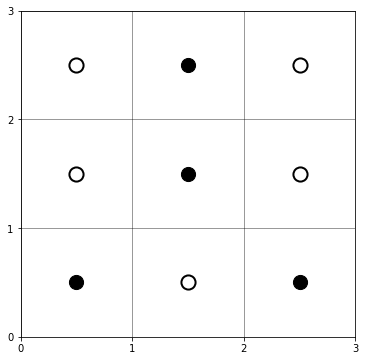

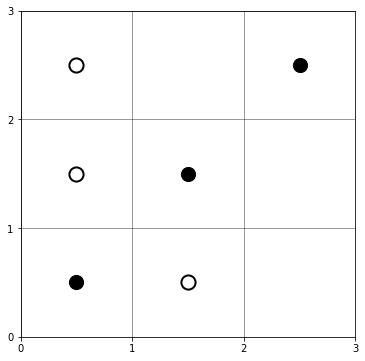

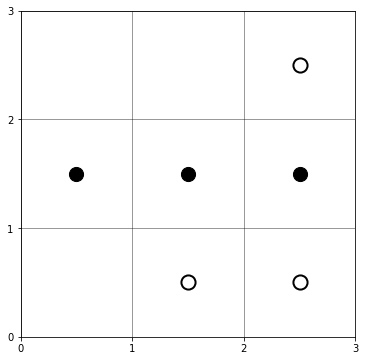

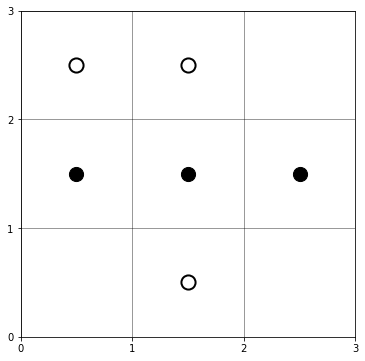

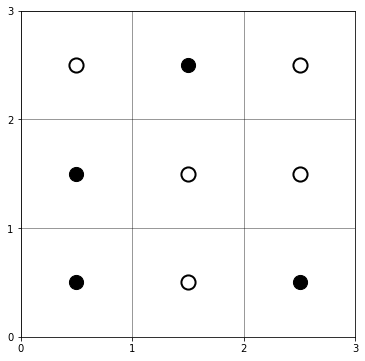

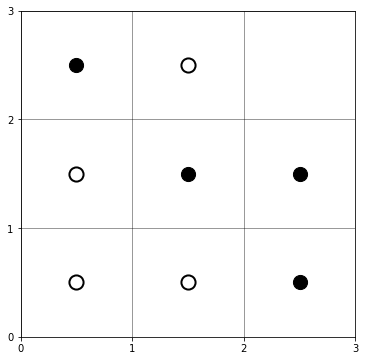

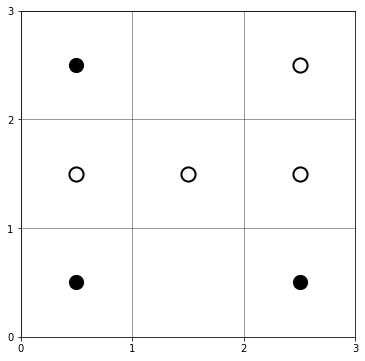

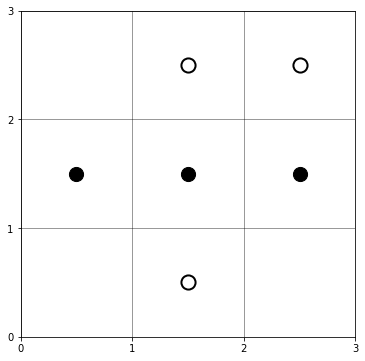

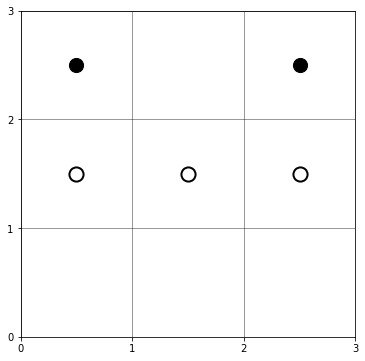

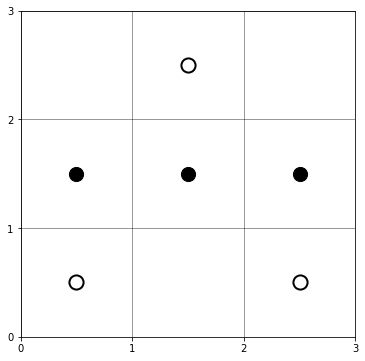

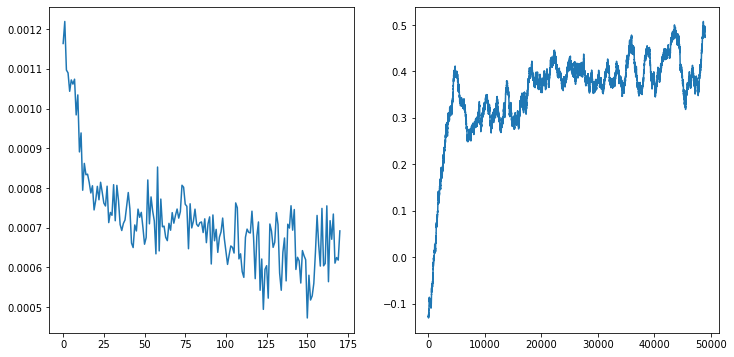

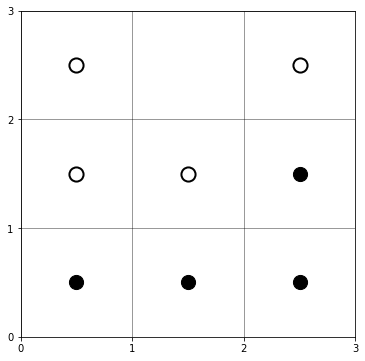

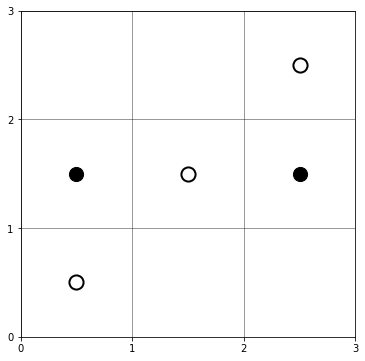

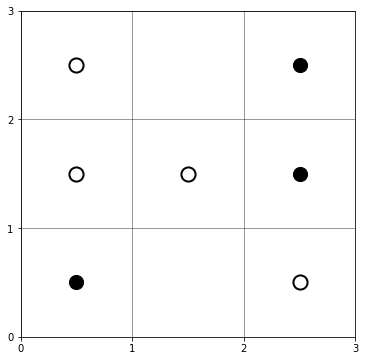

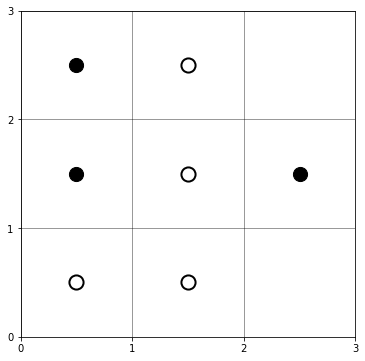

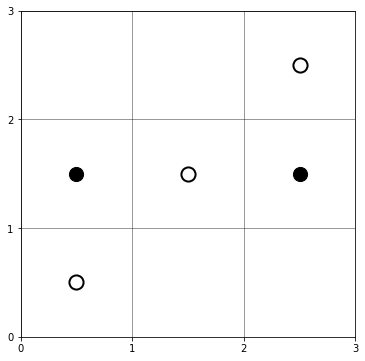

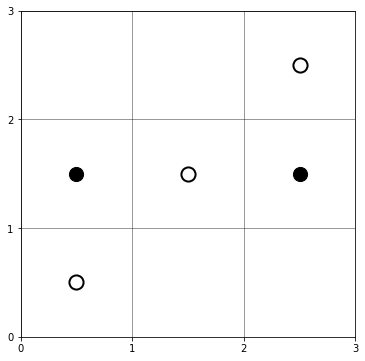

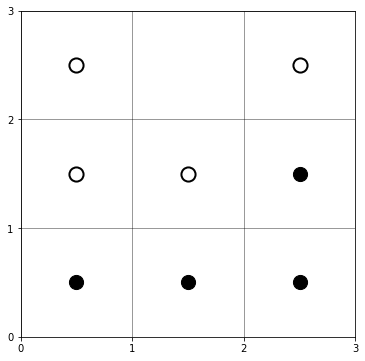

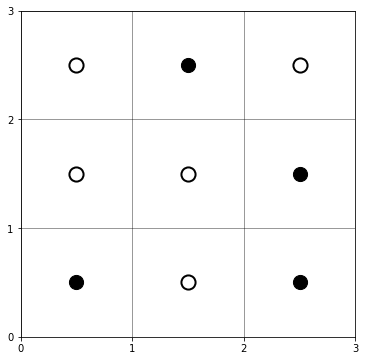

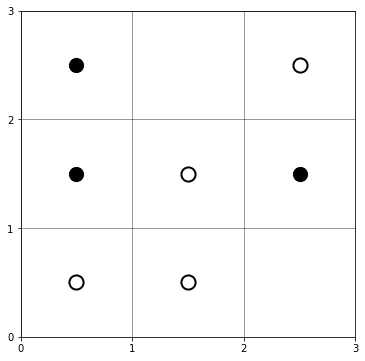

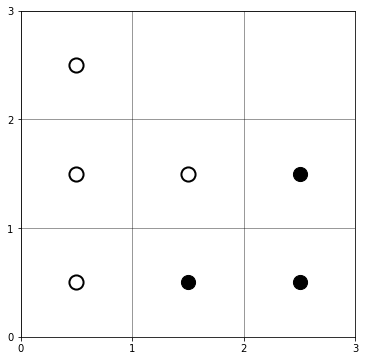

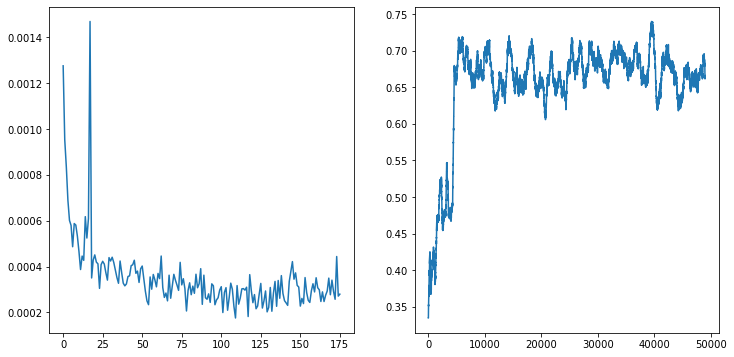

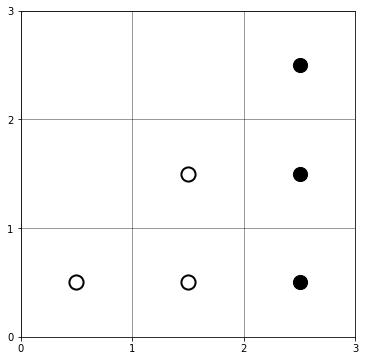

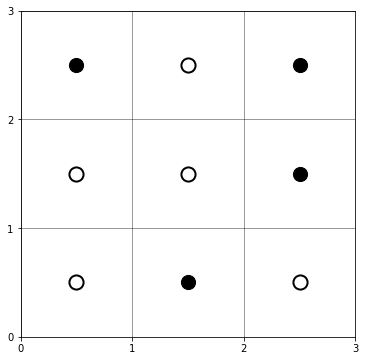

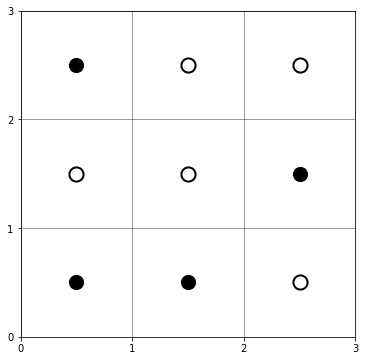

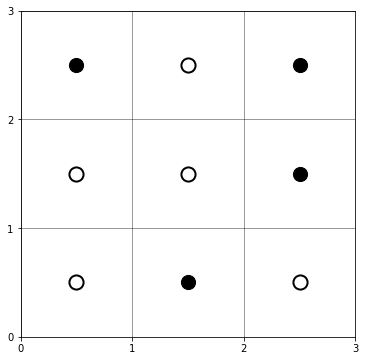

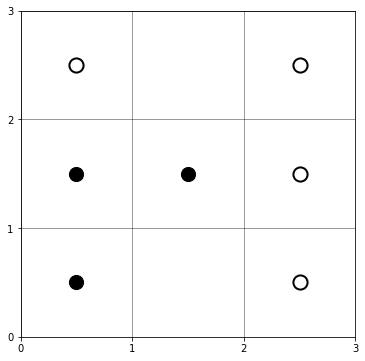

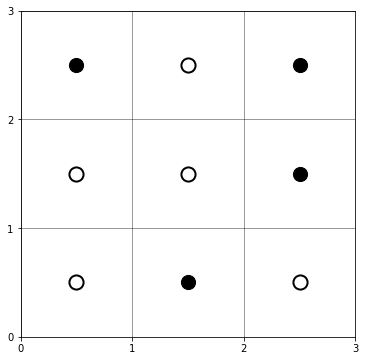

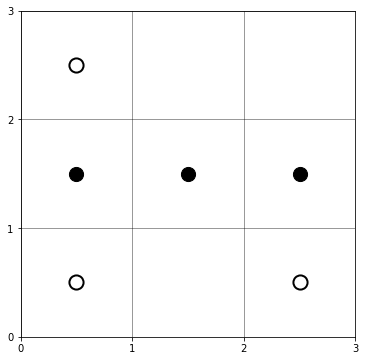

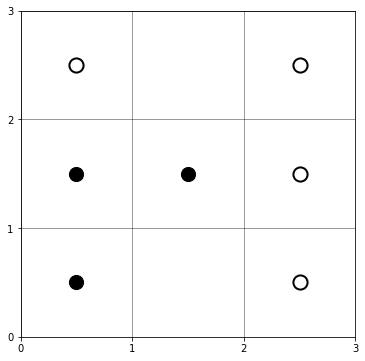

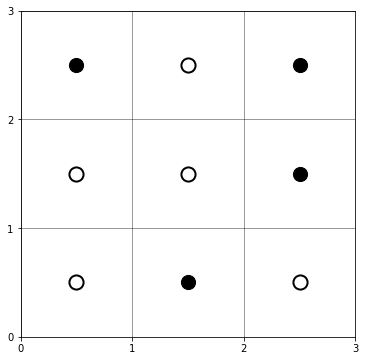

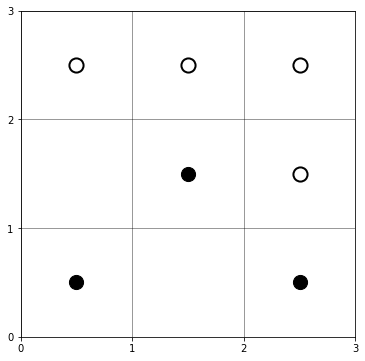

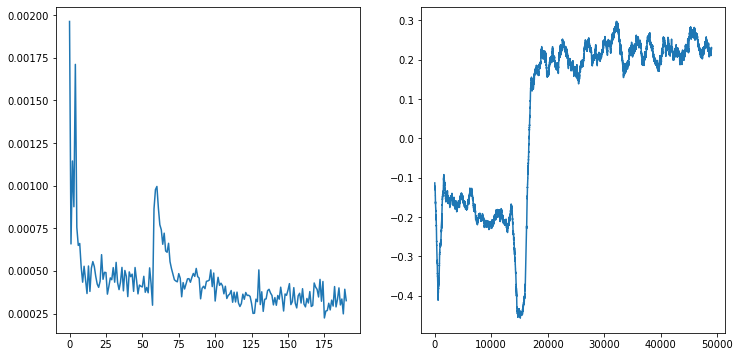

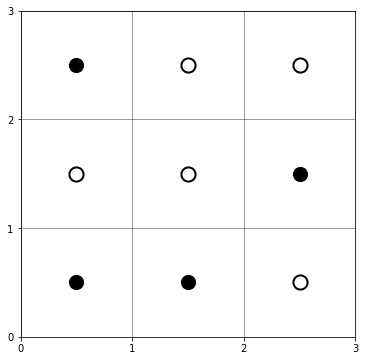

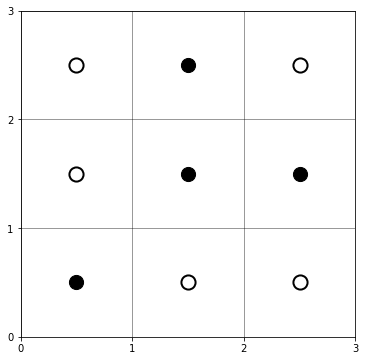

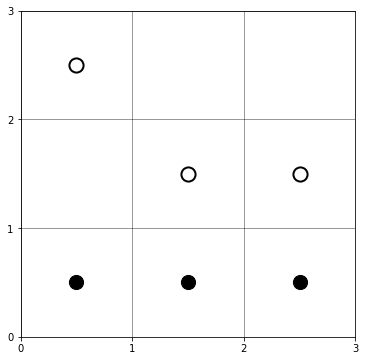

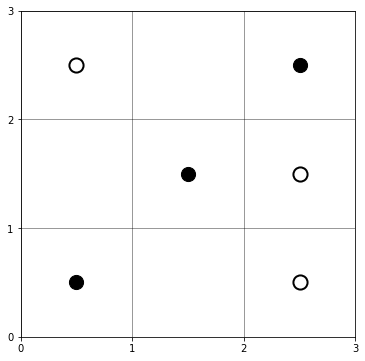

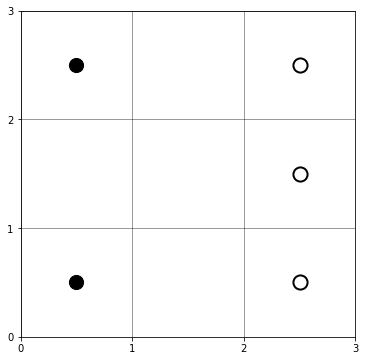

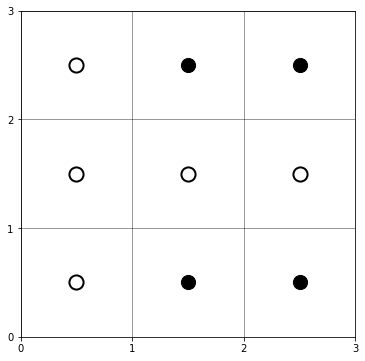

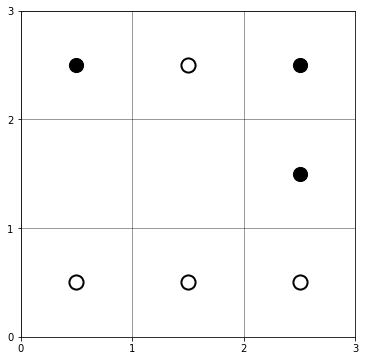

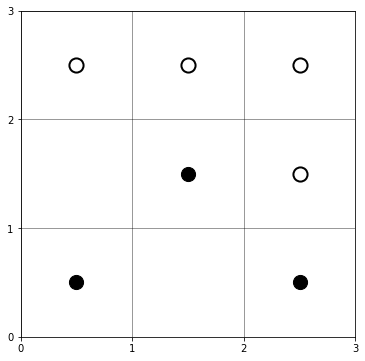

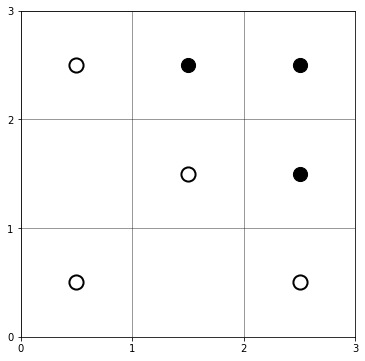

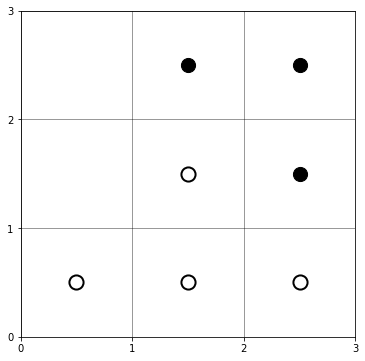

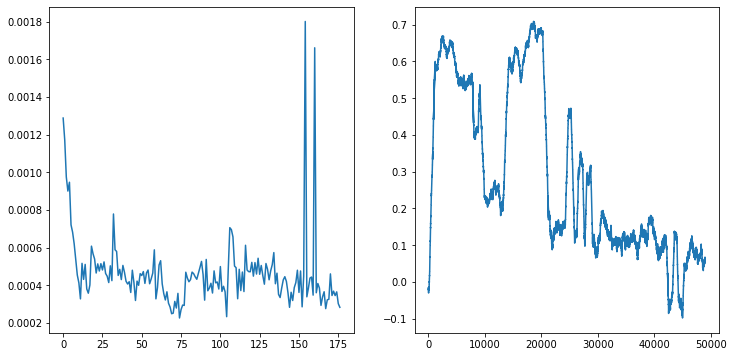

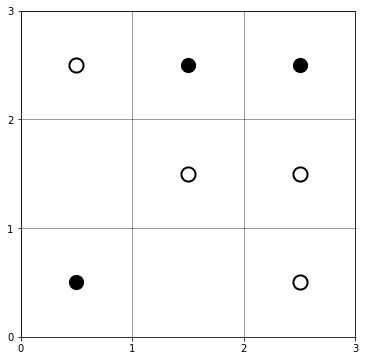

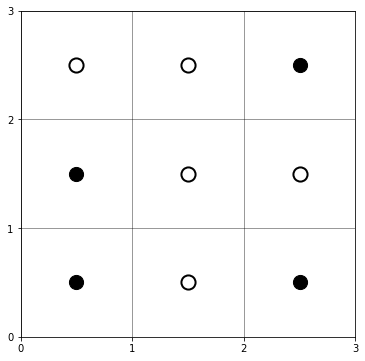

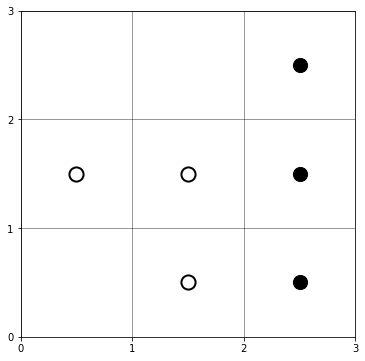

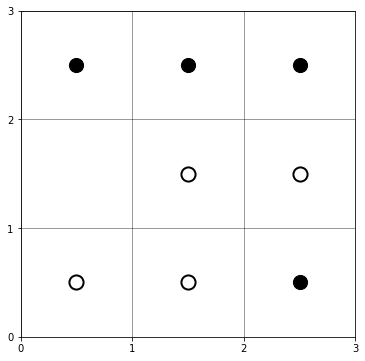

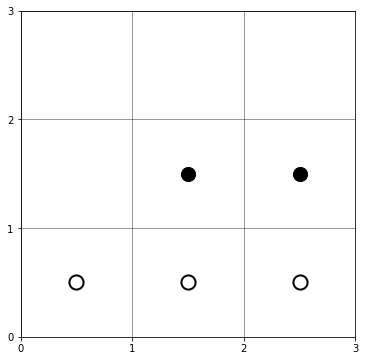

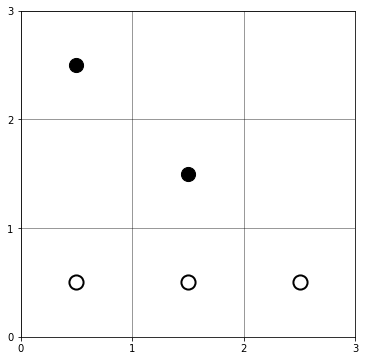

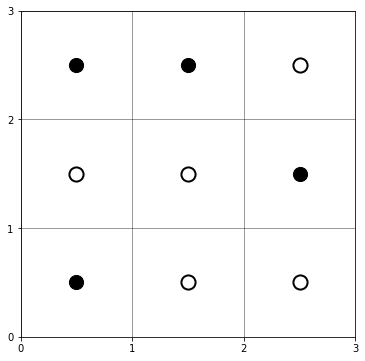

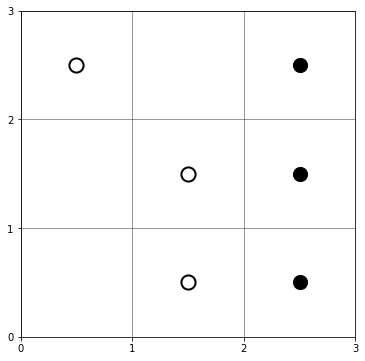

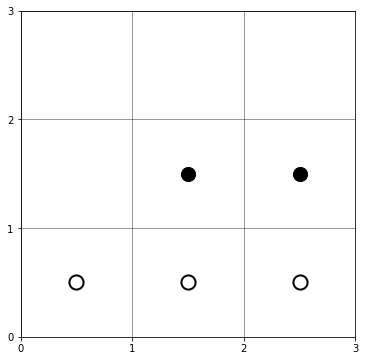

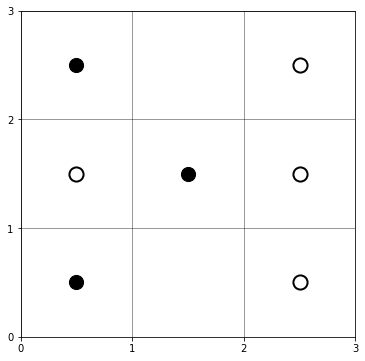

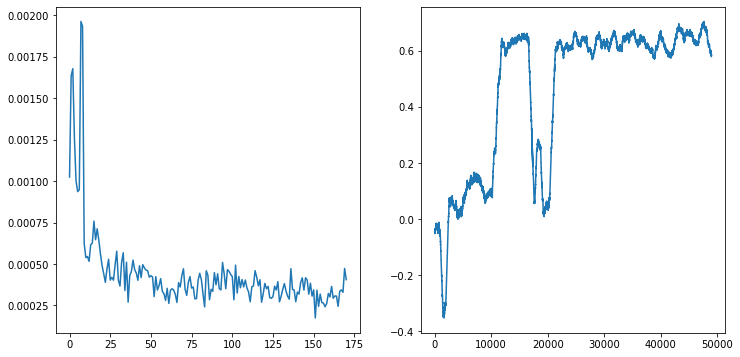

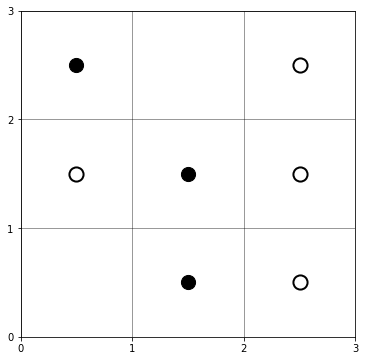

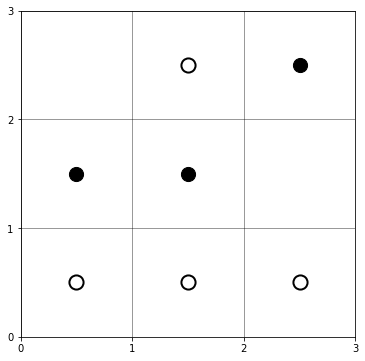

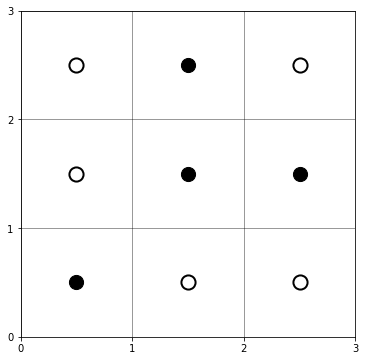

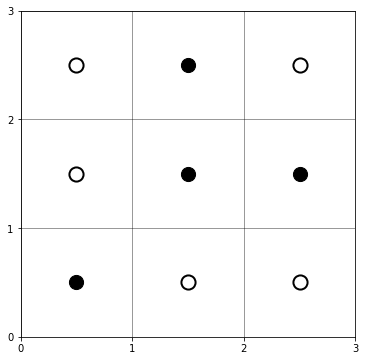

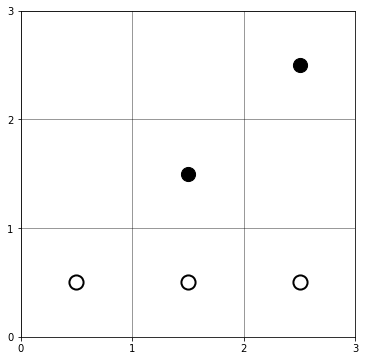

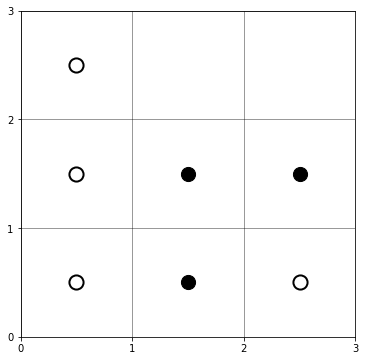

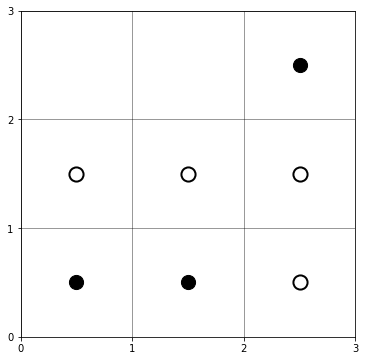

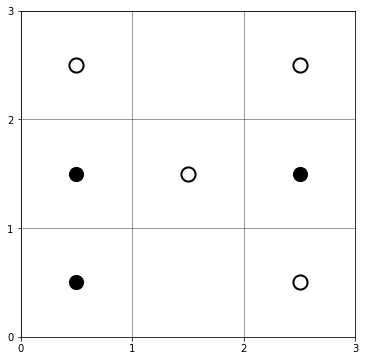

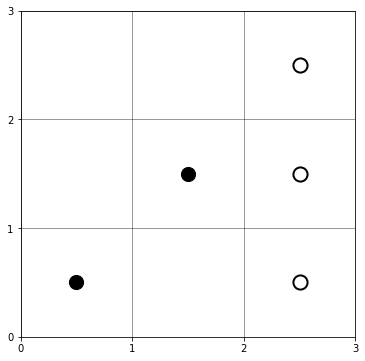

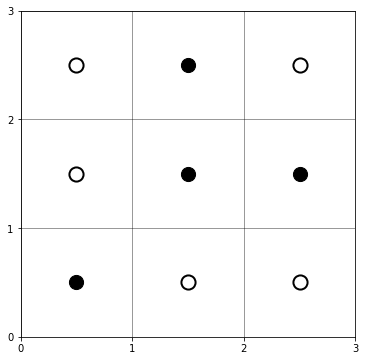

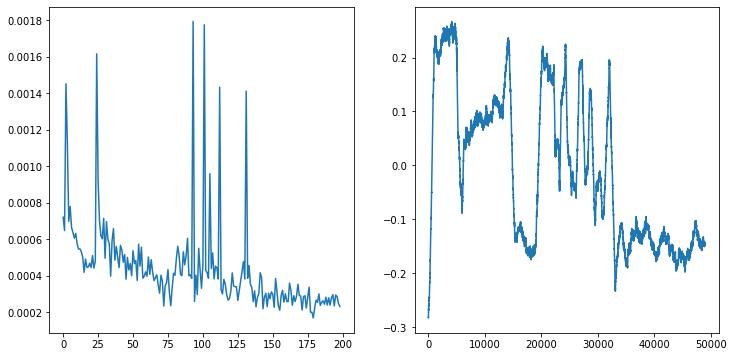

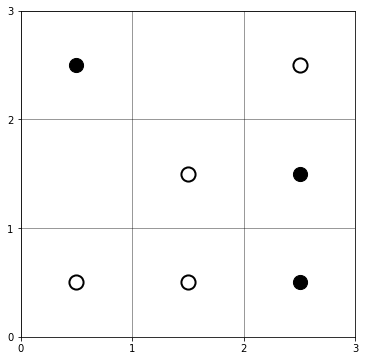

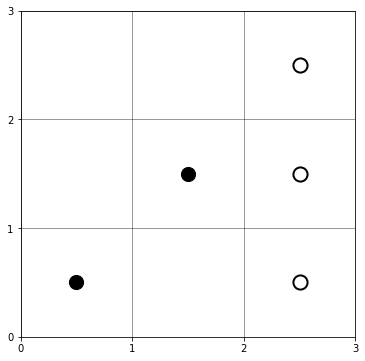

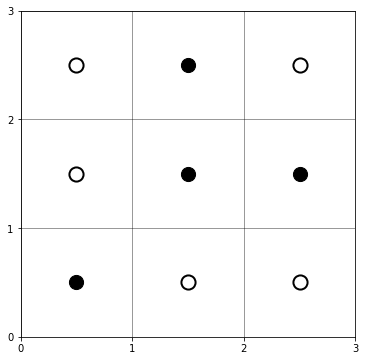

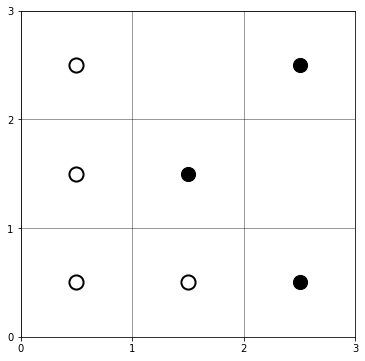

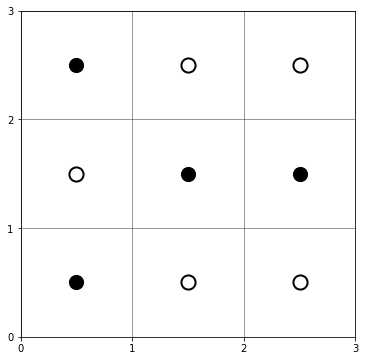

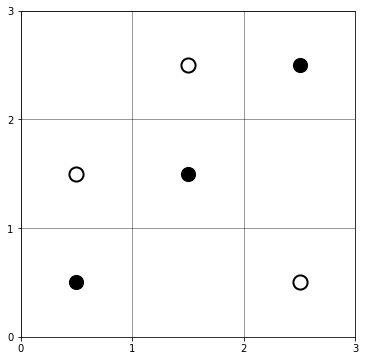

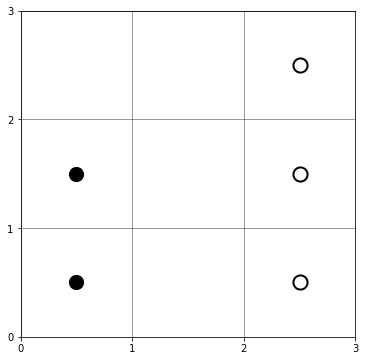

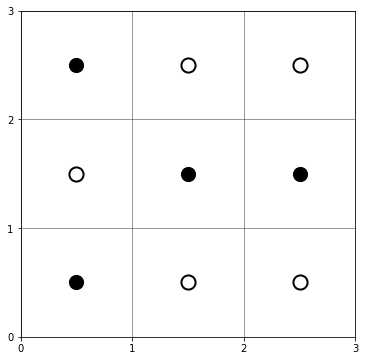

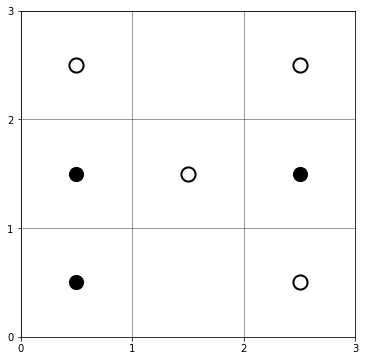

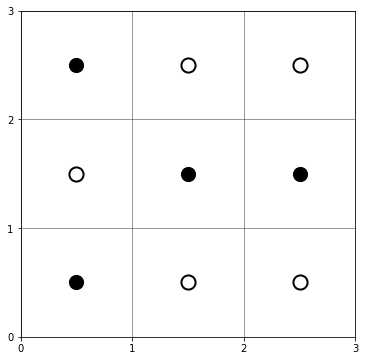

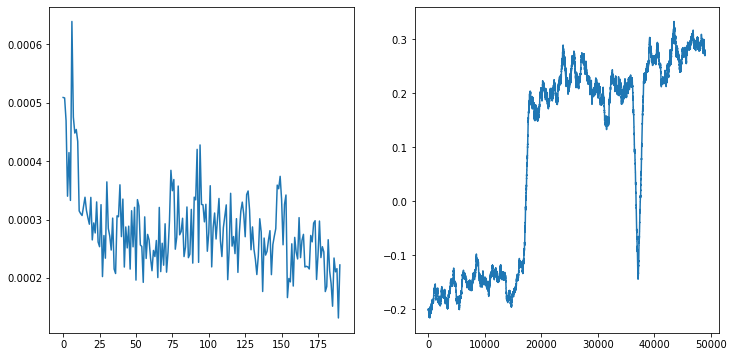

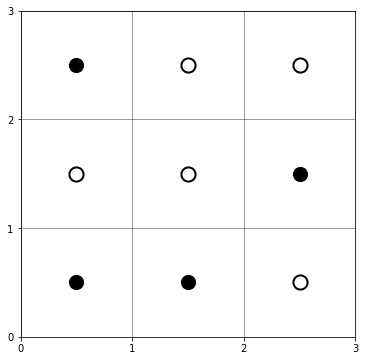

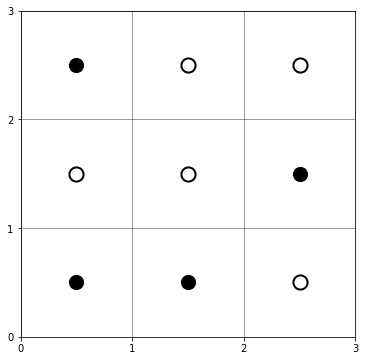

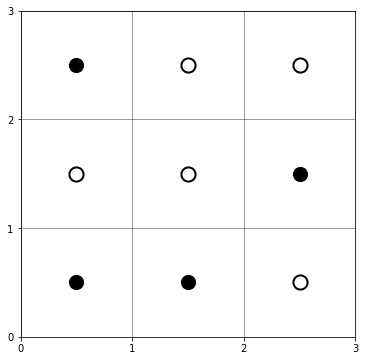

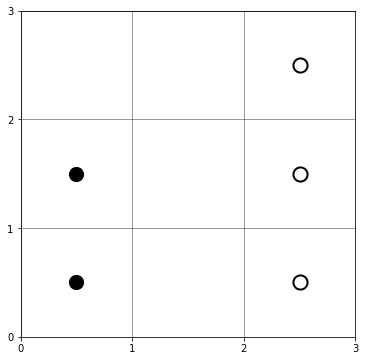

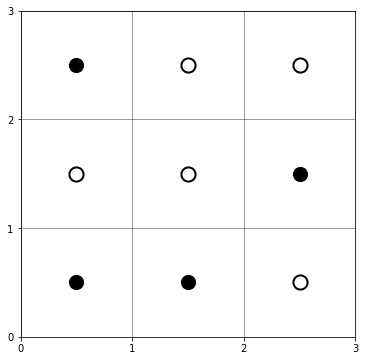

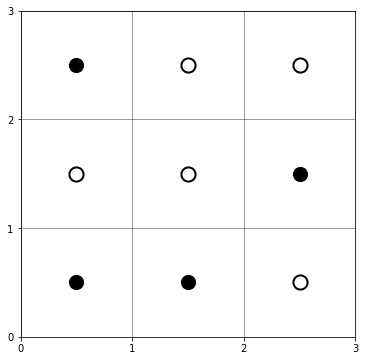

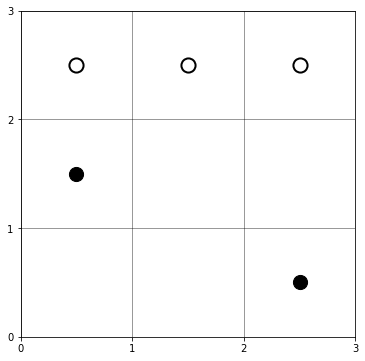

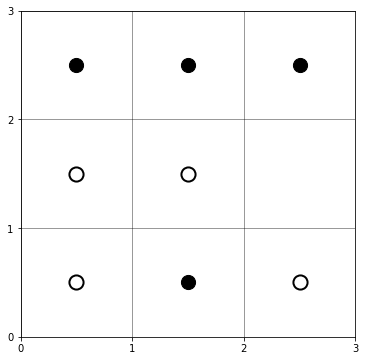

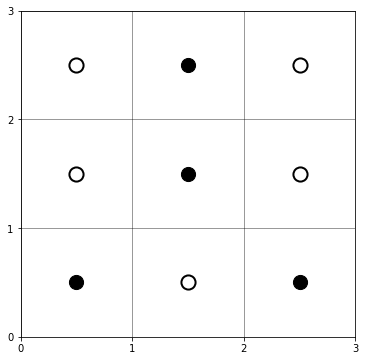

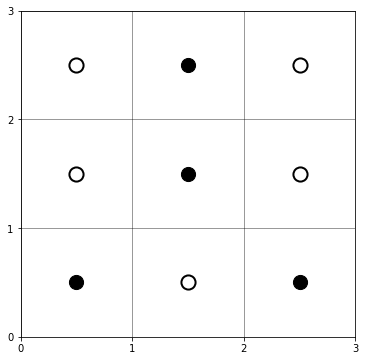

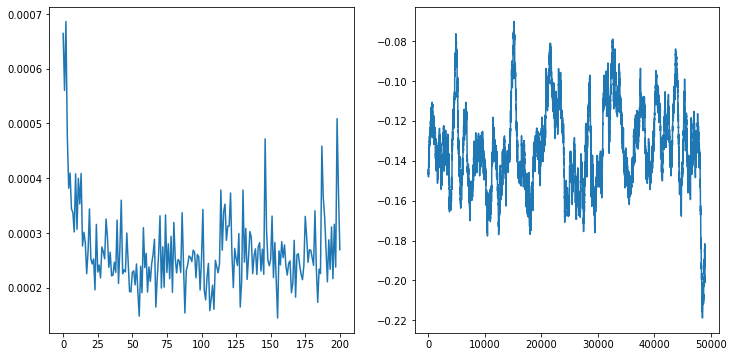

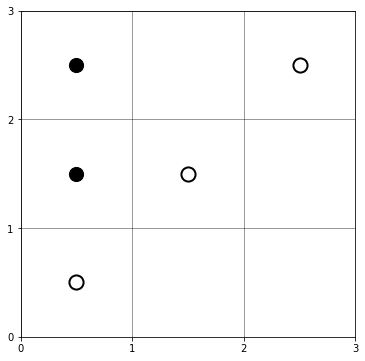

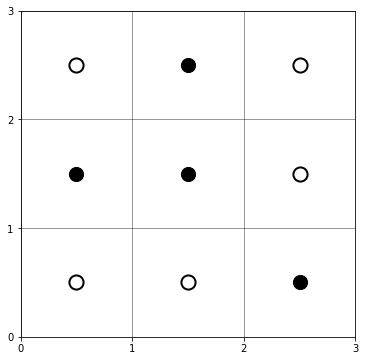

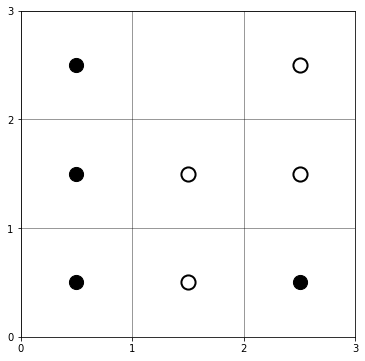

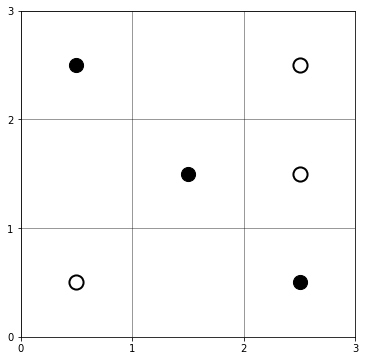

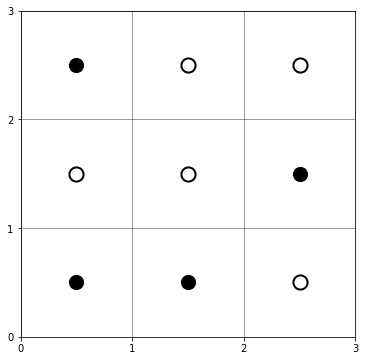

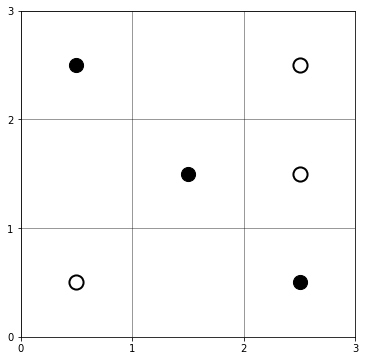

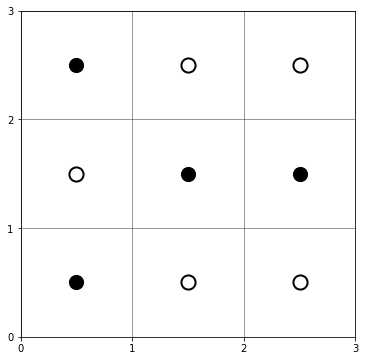

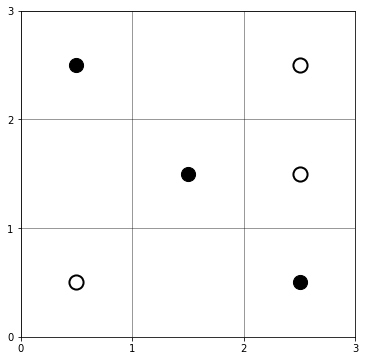

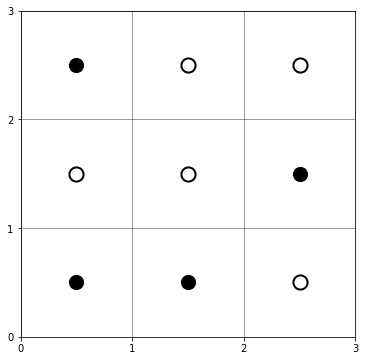

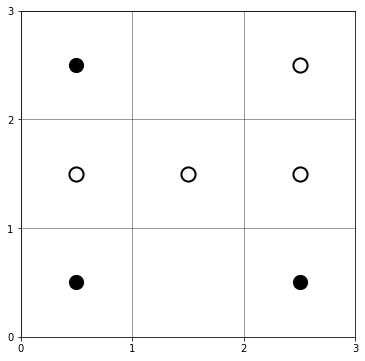

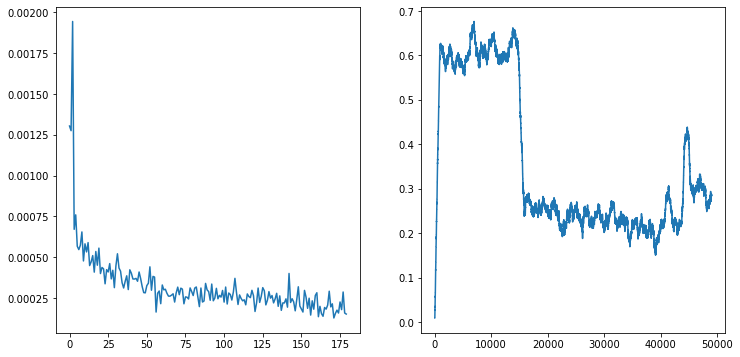

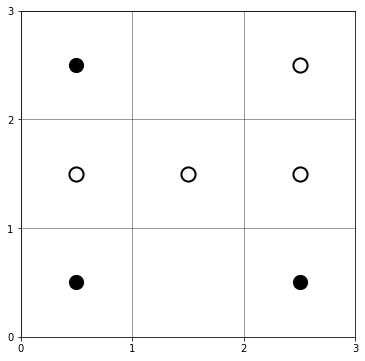

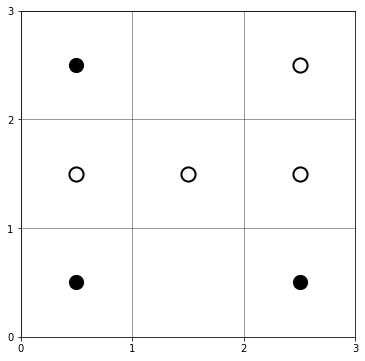

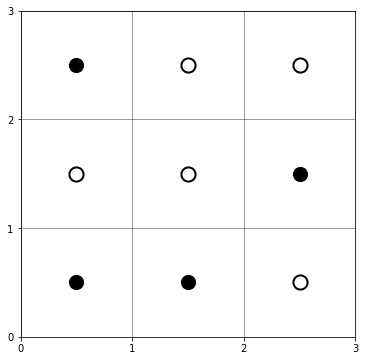

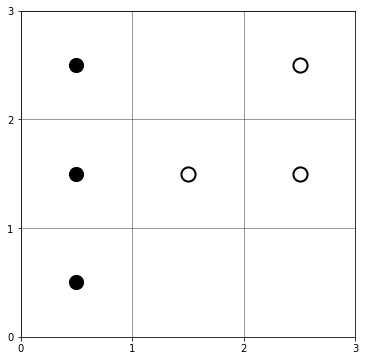

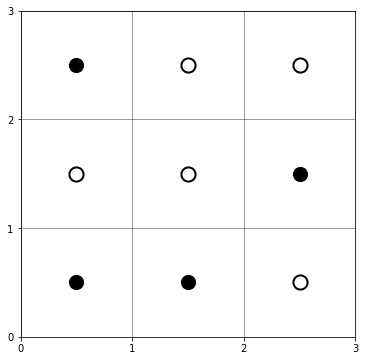

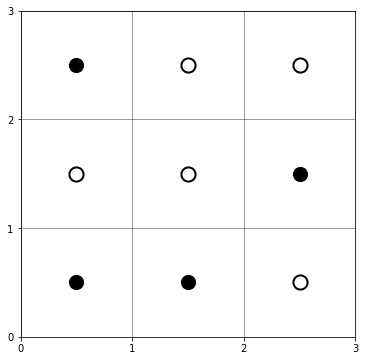

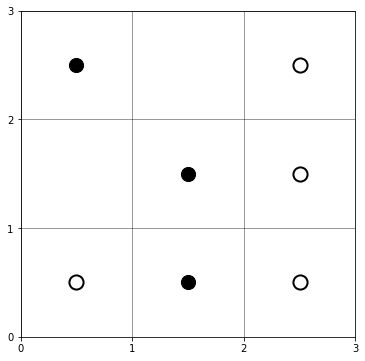

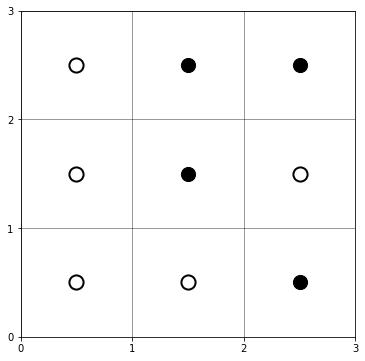

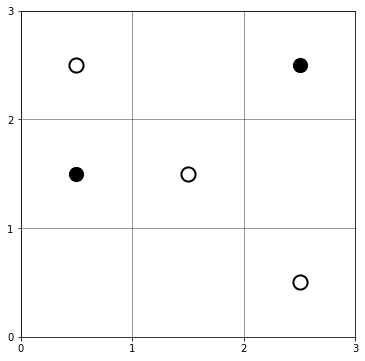

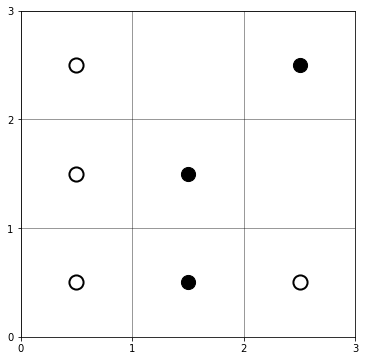

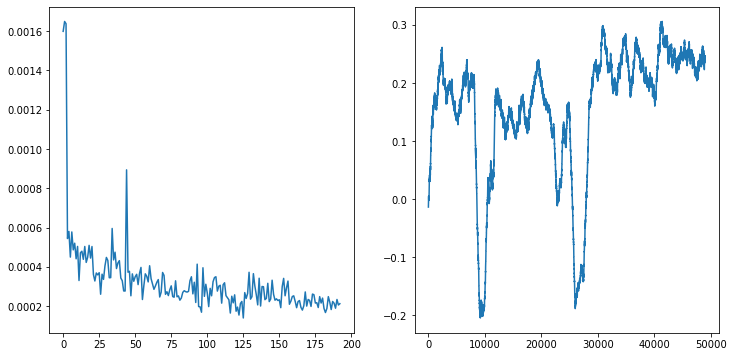

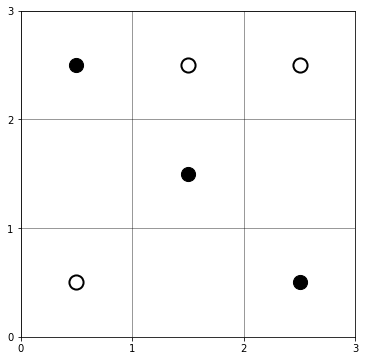

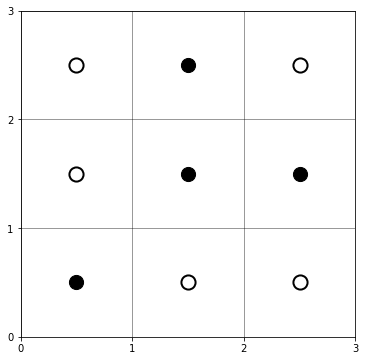

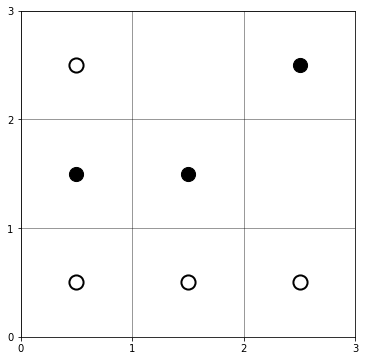

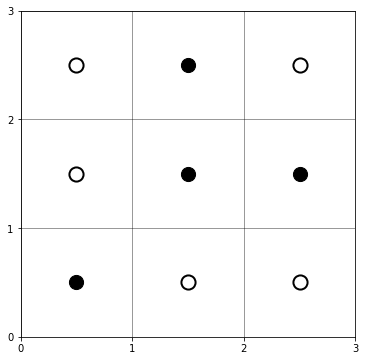

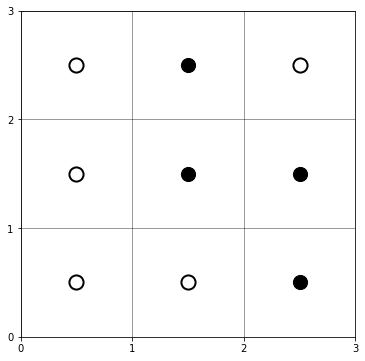

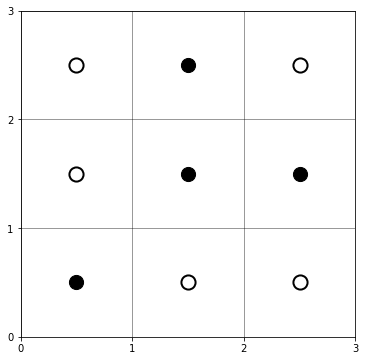

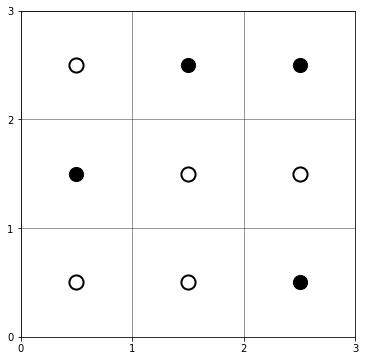

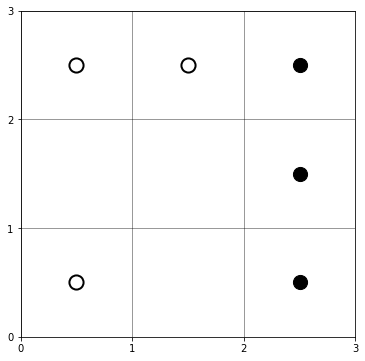

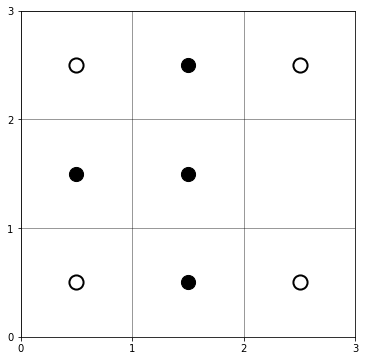

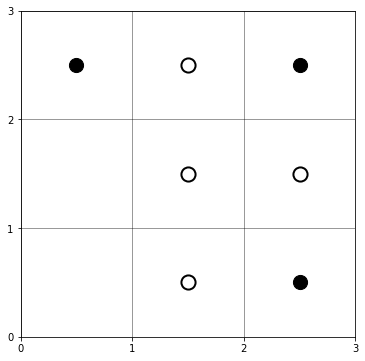

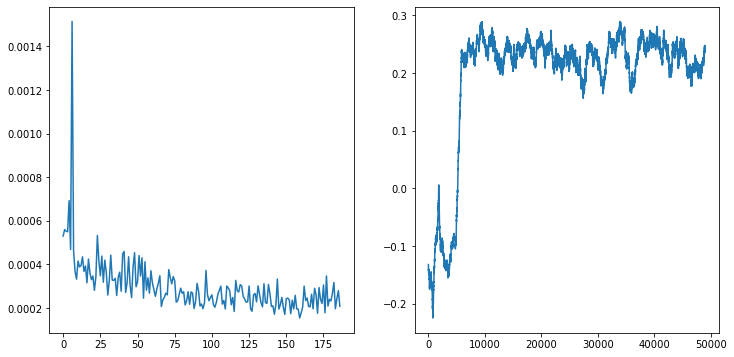

In [8]:
if __name__ == "__main__":
    train_Othello_DNN()
    for i in range(10):
        train_more_Othello_DNN(i)